In [1]:
# [CLS]トークンを利用
# anchorとtargetをそれぞれ特徴量抽出
# 多層パーセプトロンで分類器
# 特徴量抽出器の重みフリーズ

Credits to: https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train and https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

I just applied Abhishek's great code to Nakama's great notebook to create folds grouped by anchors and stratified by score. Does this close the CV-LB gap? Let's see :-)

# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    
    # General
    exp='029'
    debug=False  # False
    wandb=True
    resume=None  # [None, 'auto', 'allow', 'must']
    save_checkpoint=True
    competition='PPPM'
    seed=42

    # Dataset & DataLoader
    tokenizer_kwargs={
        'do_lower_case': True,
    }
    num_workers=4
    batch_size=12
    max_len=512

    # Model
    model="microsoft/deberta-v3-large"
    fc_dropout=0.2
    target_size=1

    # Optimizer & Scheduler
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    weight_decay=0.01
    max_grad_norm=1000

    # Train
    n_fold=4
    trn_fold=[0, 1, 2, 3]
    epochs=5
    gradient_accumulation_steps=2
    print_freq=100
    apex=True
    train=True
    

if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]


# ====================================================
# Colab settings
# ====================================================
class ColabConfig:
    dataset_name = CFG.competition
    dataset_version = 'exp' + CFG.exp
    dataset_new = True  # 新しいデータセットか
    dataset_dir = None  # Kaggle Dataset にアップロードするディレクトリ
    dataset_note = ''  # 前の版からの変更点
    in_colab = False  # colab上にデータダウンロード

In [3]:
!nvcc --version
!python -c 'import torch; print(torch.__version__) '
!python --version
print('')
!nvidia-smi
print('')
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
1.11.0+cu113
Python 3.7.13

Sat Jun 18 05:22:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                

In [4]:
%%time
import sys
COLAB = "google.colab" in sys.modules

if COLAB:
    import os
    print('This environment is Google Colab')

    # mount drive
    from google.colab import drive
    if not os.path.isdir('/content/drive'):
        drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/kaggle/PPPM/exps')

    # kaggle api token and update kaggle api
    from google.colab import files
    if not os.path.isfile('~/.kaggle/kaggle.json'):
        # files.upload()
        !mkdir -p ~/.kaggle
        !cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
        !pip install --upgrade --force-reinstall --no-deps -q kaggle

    if ColabConfig.in_colab:
        # make directory in colab
        !mkdir -p /content/input
        !mkdir -p /content/working

        # download dataset in colab
        import zipfile, glob
        os.chdir('/content/input')
        # !kaggle competitions download -qc birdclef-2022 -p birdclef-2022
        
        # !mkdir birdclef-2022
        # !cp /content/drive/MyDrive/kaggle/BirdCLEF2022/input/birdclef-2022/* ./birdclef-2022/

        for p in glob.glob('**/*.zip', recursive=True):
            print(p)
            d, f = os.path.split(p)
            # if f in ['']:
            #     continue
            with zipfile.ZipFile(p, 'r') as zipf:
                print('unzip: ', zipf)
                zipf.extractall(d)
                print('remove: ', f)
                os.remove(p)
        
        os.chdir('/content/working')

This environment is Google Colab
CPU times: user 28.9 ms, sys: 17.4 ms, total: 46.3 ms
Wall time: 1.95 s


In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/PPPM/output/{CFG.exp}/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# kaggle dataset config
ColabConfig.dataset_dir = OUTPUT_DIR

# WandB

In [6]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    !pip install -q wandb
    import wandb

    if CFG.debug:
        anony = "must"
        print('It is debugging.')
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    else:
        try:
            # from kaggle_secrets import UserSecretsClient
            # user_secrets = UserSecretsClient()
            # secret_value_0 = user_secrets.get_secret("wandb_api")
            with open('/content/drive/MyDrive/kaggle/wandb') as f:
                wandb_api_key = f.readline().rstrip('\n')
            wandb.login(key=wandb_api_key)
            anony = None
        except:
            anony = "must"
            print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    # https://docs.wandb.ai/ref/python/init
    run = wandb.init(project='PPPM', 
                        name=CFG.exp,
                        config=class2dict(CFG),
                    #  group=CFG.exp,
                        job_type="train",
                        resume=CFG.resume,  # 'auto'
                        anonymous=anony)

wandb: Currently logged in as: y-haneji. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Library

In [7]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# # 20分ぐらい
# !pip uninstall -y torch torchvision
# !pip install 'https://download.pytorch.org/whl/cu111/torch-1.10.2%2Bcu111-cp37-cp37m-linux_x86_64.whl' 'https://download.pytorch.org/whl/cu111/torchvision-0.11.3%2Bcu111-cp37-cp37m-linux_x86_64.whl'
# !git clone https://github.com/NVIDIA/apex.git
# %cd apex
# !pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# %cd ..
# # !rm -rf /content/drive/MyDrive/kaggle/PPPM/exps/apex/
# from apex import amp

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('python -m pip install sentencepiece')
os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [9]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [10]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [11]:
# contextの';' を ',' に変換する
def preprocess_context(text: str):
    text = text.replace(';', '.')
    return text

train['context_text'] = train['context_text'].map(preprocess_context)
test['context_text'] = test['context_text'].map(preprocess_context)

train['anchor'] = train['anchor'] + '.'
test['anchor'] = test['anchor'] + '.'

train['target'] = train['target'] + '.'
test['target'] = test['target'] + '.'

display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement.,abatement of pollution.,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement.,act of abating.,A47,0.75,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement.,active catalyst.,A47,0.25,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement.,eliminating process.,A47,0.50,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement.,forest region.,A47,0.00,HUMAN NECESSITIES. FURNITURE. DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum.,inorganic photoconductor drum.,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow.,altering gas flow.,F23,MECHANICAL ENGINEERING. LIGHTING. HEATING. WEA...
2,36baf228038e314b,lower trunnion.,lower locating.,B60,PERFORMING OPERATIONS. TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component.,upper portion.,D06,TEXTILES. PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation.,artificial neural network.,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


# EDA

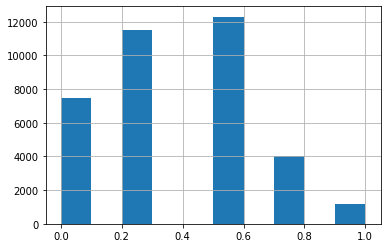

In [12]:
train['score'].hist()

In [13]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [14]:
#credits to: https://www.kaggle.com/code/abhishek/creating-folds-properly-hopefully-p

!pip install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

550 183
549 184
550 183
550 183
3    9622
0    9379
1    8860
2    8612
Name: fold, dtype: int64


In [15]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [16]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model, **CFG.tokenizer_kwargs)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Dataset

In [17]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(
                max(lengths_dict['anchor']) + max(lengths_dict['context_text']),
                max(lengths_dict['target']) + max(lengths_dict['context_text'])
              ) + 3 # CLS + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 100


In [18]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text, context):
    inputs = cfg.tokenizer(text, context,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df, phase: str ='train'):
        self.cfg = cfg
        self.anchors = df['anchor'].values
        self.targets = df['target'].values
        self.contexts = df['context_text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        anchor_inputs = prepare_input(self.cfg, self.anchors[item], self.contexts[item])
        target_inputs = prepare_input(self.cfg, self.targets[item], self.contexts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return anchor_inputs, target_inputs, label

In [19]:
# train_dataset = TrainDataset(CFG, train, 'train')
# anchor_inputs, target_inputs, label = train_dataset[0]
# print(anchor_inputs)
# print(target_inputs)
# print(label)

# Model

In [20]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self._freeze_weights(self.model)
        # self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        # self.fc = nn.Linear(self.config.hidden_size * 2, self.cfg.target_size)  # anchorとtargetののhidden_statesををconcatするから2倍
        self.cls = nn.Sequential(  # MLP
            nn.Dropout(cfg.fc_dropout),
            nn.Linear(self.config.hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(cfg.fc_dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(cfg.fc_dropout),
            nn.Linear(256, self.cfg.target_size)
        )
        self._init_weights(self.cls)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def _freeze_weights(self, module):
        for param in module.parameters():
            param.requires_grad = False # freeze weights in at all
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]  # (bs, max_len, hidden_size)
        feature = last_hidden_states[:, 0, :]  # [CLS]トークンを利用
        # feature = torch.mean(last_hidden_states, dim=1)  # 全トークンを平均
        # weights = self.attention(last_hidden_states)
        # feature = torch.sum(weights * last_hidden_states, dim=1)  # 全トークンを全トークンをattentionレイヤで加重平均
        return feature

    def forward(self, anchor_inputs, target_inputs):
        anchor_feature = self.feature(anchor_inputs)
        target_feature = self.feature(target_inputs)
        feature = torch.cat([anchor_feature, target_feature], dim=1)
        output = self.cls(feature)
        return output

# Helpler functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (anchor_inputs, target_inputs, labels) in enumerate(train_loader):
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(anchor_inputs, target_inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (anchor_inputs, target_inputs, labels) in enumerate(valid_loader):
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(anchor_inputs, target_inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for anchor_inputs, target_inputs in tk0:
        for inputs in [anchor_inputs, target_inputs]:
            for k, v in inputs.items():
                inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(anchor_inputs, target_inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [22]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, checkpoint_path=None,):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds, phase='train')
    valid_dataset = TrainDataset(CFG, valid_folds, phase='val')

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size / CFG.gradient_accumulation_steps * CFG.epochs)
    CFG.num_warmup_steps = int(num_train_steps * 0.1)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.
    epoch = 0

    if wandb.run.resumed and (checkpoint['epoch'] < CFG.epochs - 1):  # foldの終わりで止まっている時もある
        checkpoint = torch.load(checkpoint_path)  # wandb.restore(checkpoint_path)
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['model'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        # amp.load_state_dict(checkpoint['amp'])
        epoch = checkpoint['epoeh'] + 1  # 保存時のエポックが読み出されるので+1
        best_score = checkpoint['best_score']

    while epoch < CFG.epochs:
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if CFG.save_checkpoint:
            torch.save({'model': model.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(),
                        # 'amp': amp.state_dict(),
                        'epoch': epoch,
                        'best_score': best_score},
                        checkpoint_path)
            # wandb.save(checkpoint_path)  # driveでos.symlinkでエラーが出る

        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
            
        epoch += 1

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [23]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        fold = 0

        if wandb.run.resumed:
            checkpoint = torch.load(OUTPUT_DIR + 'fold_checkpoint.pth')
            fold = checkpoint['fold'] + 1  # 保存時のfoldが読み出されるので+1
            oof_df = checkpoint['oof_df']

        while fold < CFG.n_fold:
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold, checkpoint_path=OUTPUT_DIR + 'epoch_checkpoint.pth')
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
            if CFG.save_checkpoint:
                torch.save({'fold': fold,
                            'oof_df': oof_df},
                            OUTPUT_DIR + 'fold_checkpoint.pth')
            fold += 1

        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb & (~CFG.debug):
        wandb.finish()

    os.remove(OUTPUT_DIR + 'fold_checkpoint.pth')
    os.remove(OUTPUT_DIR + 'epoch_checkpoint.pth')

========== fold: 0 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClas

Epoch: [1][0/2257] Elapsed 0m 0s (remain 28m 44s) Loss: 0.3456(0.3456) Grad: 37402.5391  LR: 0.00000000  
Epoch: [1][100/2257] Elapsed 0m 37s (remain 13m 22s) Loss: 0.3541(0.3514) Grad: 27062.6113  LR: 0.00000177  
Epoch: [1][200/2257] Elapsed 1m 14s (remain 12m 40s) Loss: 0.3455(0.3470) Grad: 20818.8516  LR: 0.00000355  
Epoch: [1][300/2257] Elapsed 1m 51s (remain 12m 3s) Loss: 0.3369(0.3428) Grad: 15805.6914  LR: 0.00000532  
Epoch: [1][400/2257] Elapsed 2m 28s (remain 11m 25s) Loss: 0.3078(0.3396) Grad: 29043.3105  LR: 0.00000709  
Epoch: [1][500/2257] Elapsed 3m 4s (remain 10m 48s) Loss: 0.3584(0.3376) Grad: 36569.5703  LR: 0.00000887  
Epoch: [1][600/2257] Elapsed 3m 41s (remain 10m 10s) Loss: 0.2874(0.3353) Grad: 32860.5742  LR: 0.00001064  
Epoch: [1][700/2257] Elapsed 4m 18s (remain 9m 33s) Loss: 0.3175(0.3339) Grad: 22553.1387  LR: 0.00001241  
Epoch: [1][800/2257] Elapsed 4m 55s (remain 8m 56s) Loss: 0.3367(0.3330) Grad: 18769.7910  LR: 0.00001418  
Epoch: [1][900/2257] Elaps

Epoch 1 - avg_train_loss: 0.3298  avg_val_loss: 0.3283  time: 1084s
Epoch 1 - Score: 0.0294


EVAL: [781/782] Elapsed 4m 12s (remain 0m 0s) Loss: 0.3803(0.3283) 


Epoch 1 - Save Best Score: 0.0294 Model


Epoch: [2][0/2257] Elapsed 0m 1s (remain 39m 57s) Loss: 0.3654(0.3654) Grad: 32401.1367  LR: 0.00001940  
Epoch: [2][100/2257] Elapsed 0m 38s (remain 13m 51s) Loss: 0.3527(0.3283) Grad: 34857.2891  LR: 0.00001929  
Epoch: [2][200/2257] Elapsed 1m 16s (remain 12m 57s) Loss: 0.3761(0.3263) Grad: 44657.6641  LR: 0.00001917  
Epoch: [2][300/2257] Elapsed 1m 52s (remain 12m 13s) Loss: 0.3220(0.3268) Grad: 20423.9609  LR: 0.00001904  
Epoch: [2][400/2257] Elapsed 2m 29s (remain 11m 32s) Loss: 0.3379(0.3269) Grad: 19716.1465  LR: 0.00001890  
Epoch: [2][500/2257] Elapsed 3m 6s (remain 10m 53s) Loss: 0.3229(0.3266) Grad: 22591.0098  LR: 0.00001876  
Epoch: [2][600/2257] Elapsed 3m 43s (remain 10m 14s) Loss: 0.3292(0.3269) Grad: 25175.8418  LR: 0.00001861  
Epoch: [2][700/2257] Elapsed 4m 19s (remain 9m 36s) Loss: 0.3456(0.3272) Grad: 25271.4707  LR: 0.00001844  
Epoch: [2][800/2257] Elapsed 4m 56s (remain 8m 59s) Loss: 0.3157(0.3277) Grad: 28316.5449  LR: 0.00001827  
Epoch: [2][900/2257] Elap

Epoch 2 - avg_train_loss: 0.3275  avg_val_loss: 0.3293  time: 1086s
Epoch 2 - Score: 0.0404


EVAL: [781/782] Elapsed 4m 13s (remain 0m 0s) Loss: 0.3978(0.3293) 


Epoch 2 - Save Best Score: 0.0404 Model


Epoch: [3][0/2257] Elapsed 0m 0s (remain 26m 45s) Loss: 0.3257(0.3257) Grad: 20391.5664  LR: 0.00001501  
Epoch: [3][100/2257] Elapsed 0m 38s (remain 13m 42s) Loss: 0.3516(0.3254) Grad: 23636.8965  LR: 0.00001474  
Epoch: [3][200/2257] Elapsed 1m 15s (remain 12m 57s) Loss: 0.3732(0.3278) Grad: 39373.7227  LR: 0.00001446  
Epoch: [3][300/2257] Elapsed 1m 52s (remain 12m 13s) Loss: 0.3467(0.3266) Grad: 22409.8828  LR: 0.00001418  
Epoch: [3][400/2257] Elapsed 2m 29s (remain 11m 32s) Loss: 0.3355(0.3271) Grad: 18751.6387  LR: 0.00001390  
Epoch: [3][500/2257] Elapsed 3m 6s (remain 10m 53s) Loss: 0.2833(0.3275) Grad: 31721.4629  LR: 0.00001361  
Epoch: [3][600/2257] Elapsed 3m 43s (remain 10m 14s) Loss: 0.3219(0.3274) Grad: 21077.1680  LR: 0.00001332  
Epoch: [3][700/2257] Elapsed 4m 19s (remain 9m 36s) Loss: 0.3184(0.3269) Grad: 15193.9531  LR: 0.00001303  
Epoch: [3][800/2257] Elapsed 4m 56s (remain 8m 59s) Loss: 0.3403(0.3274) Grad: 18956.0039  LR: 0.00001274  
Epoch: [3][900/2257] Elap

Epoch 3 - avg_train_loss: 0.3275  avg_val_loss: 0.3283  time: 1086s
Epoch 3 - Score: 0.0632


EVAL: [781/782] Elapsed 4m 13s (remain 0m 0s) Loss: 0.3887(0.3283) 


Epoch 3 - Save Best Score: 0.0632 Model


Epoch: [4][0/2257] Elapsed 0m 0s (remain 24m 37s) Loss: 0.2856(0.2856) Grad: 31151.4688  LR: 0.00000828  
Epoch: [4][100/2257] Elapsed 0m 38s (remain 13m 36s) Loss: 0.3339(0.3227) Grad: 20818.7988  LR: 0.00000797  
Epoch: [4][200/2257] Elapsed 1m 15s (remain 12m 55s) Loss: 0.3038(0.3259) Grad: 25714.5859  LR: 0.00000767  
Epoch: [4][300/2257] Elapsed 1m 52s (remain 12m 12s) Loss: 0.3091(0.3255) Grad: 16535.5215  LR: 0.00000737  
Epoch: [4][400/2257] Elapsed 2m 29s (remain 11m 32s) Loss: 0.3265(0.3259) Grad: 19119.6113  LR: 0.00000707  
Epoch: [4][500/2257] Elapsed 3m 6s (remain 10m 53s) Loss: 0.2796(0.3255) Grad: 31510.0312  LR: 0.00000678  
Epoch: [4][600/2257] Elapsed 3m 43s (remain 10m 14s) Loss: 0.3103(0.3261) Grad: 23327.1074  LR: 0.00000649  
Epoch: [4][700/2257] Elapsed 4m 19s (remain 9m 36s) Loss: 0.3170(0.3258) Grad: 18773.0488  LR: 0.00000620  
Epoch: [4][800/2257] Elapsed 4m 56s (remain 8m 59s) Loss: 0.3136(0.3262) Grad: 19526.1523  LR: 0.00000592  
Epoch: [4][900/2257] Elap

Epoch 4 - avg_train_loss: 0.3272  avg_val_loss: 0.3282  time: 1086s
Epoch 4 - Score: 0.0615


EVAL: [781/782] Elapsed 4m 13s (remain 0m 0s) Loss: 0.3847(0.3282) 
Epoch: [5][0/2257] Elapsed 0m 0s (remain 25m 51s) Loss: 0.3423(0.3423) Grad: 22816.0566  LR: 0.00000235  
Epoch: [5][100/2257] Elapsed 0m 37s (remain 13m 30s) Loss: 0.3068(0.3252) Grad: 23880.9277  LR: 0.00000216  
Epoch: [5][200/2257] Elapsed 1m 14s (remain 12m 45s) Loss: 0.3042(0.3252) Grad: 19464.9707  LR: 0.00000197  
Epoch: [5][300/2257] Elapsed 1m 51s (remain 12m 4s) Loss: 0.3123(0.3262) Grad: 14526.9180  LR: 0.00000179  
Epoch: [5][400/2257] Elapsed 2m 28s (remain 11m 26s) Loss: 0.3504(0.3278) Grad: 21013.5273  LR: 0.00000162  
Epoch: [5][500/2257] Elapsed 3m 5s (remain 10m 49s) Loss: 0.3210(0.3274) Grad: 22767.2402  LR: 0.00000145  
Epoch: [5][600/2257] Elapsed 3m 42s (remain 10m 11s) Loss: 0.3094(0.3275) Grad: 21322.3555  LR: 0.00000129  
Epoch: [5][700/2257] Elapsed 4m 18s (remain 9m 34s) Loss: 0.2968(0.3277) Grad: 25850.6582  LR: 0.00000115  
Epoch: [5][800/2257] Elapsed 4m 55s (remain 8m 57s) Loss: 0.2869(0

Epoch 5 - avg_train_loss: 0.3272  avg_val_loss: 0.3282  time: 1085s
Epoch 5 - Score: 0.0637


EVAL: [781/782] Elapsed 4m 13s (remain 0m 0s) Loss: 0.3844(0.3282) 


Epoch 5 - Save Best Score: 0.0637 Model
========== fold: 0 result ==========
Score: 0.0637
========== fold: 1 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exact

Epoch: [1][0/2301] Elapsed 0m 0s (remain 34m 3s) Loss: 0.3695(0.3695) Grad: 69022.6016  LR: 0.00000000  
Epoch: [1][100/2301] Elapsed 0m 38s (remain 14m 3s) Loss: 0.3476(0.3558) Grad: 28030.7520  LR: 0.00000174  
Epoch: [1][200/2301] Elapsed 1m 16s (remain 13m 16s) Loss: 0.3509(0.3516) Grad: 27826.3926  LR: 0.00000348  
Epoch: [1][300/2301] Elapsed 1m 53s (remain 12m 32s) Loss: 0.3370(0.3466) Grad: 15693.2471  LR: 0.00000522  
Epoch: [1][400/2301] Elapsed 2m 30s (remain 11m 50s) Loss: 0.3114(0.3426) Grad: 25126.1484  LR: 0.00000696  
Epoch: [1][500/2301] Elapsed 3m 6s (remain 11m 10s) Loss: 0.3171(0.3390) Grad: 21036.4023  LR: 0.00000870  
Epoch: [1][600/2301] Elapsed 3m 43s (remain 10m 32s) Loss: 0.3439(0.3374) Grad: 30162.2285  LR: 0.00001043  
Epoch: [1][700/2301] Elapsed 4m 20s (remain 9m 54s) Loss: 0.3503(0.3358) Grad: 26189.2188  LR: 0.00001217  
Epoch: [1][800/2301] Elapsed 4m 57s (remain 9m 16s) Loss: 0.3107(0.3345) Grad: 22418.4121  LR: 0.00001391  
Epoch: [1][900/2301] Elapse

Epoch 1 - avg_train_loss: 0.3302  avg_val_loss: 0.3280  time: 1089s
Epoch 1 - Score: 0.0360


EVAL: [738/739] Elapsed 3m 59s (remain 0m 0s) Loss: 0.3852(0.3280) 


Epoch 1 - Save Best Score: 0.0360 Model


Epoch: [2][0/2301] Elapsed 0m 0s (remain 27m 56s) Loss: 0.3334(0.3334) Grad: 17466.9766  LR: 0.00001940  
Epoch: [2][100/2301] Elapsed 0m 39s (remain 14m 23s) Loss: 0.3386(0.3279) Grad: 19165.6602  LR: 0.00001929  
Epoch: [2][200/2301] Elapsed 1m 16s (remain 13m 21s) Loss: 0.3354(0.3266) Grad: 17050.4590  LR: 0.00001917  
Epoch: [2][300/2301] Elapsed 1m 53s (remain 12m 33s) Loss: 0.3352(0.3251) Grad: 25001.3789  LR: 0.00001905  
Epoch: [2][400/2301] Elapsed 2m 30s (remain 11m 52s) Loss: 0.3239(0.3266) Grad: 20102.6504  LR: 0.00001891  
Epoch: [2][500/2301] Elapsed 3m 7s (remain 11m 12s) Loss: 0.3184(0.3268) Grad: 14710.2520  LR: 0.00001877  
Epoch: [2][600/2301] Elapsed 3m 43s (remain 10m 33s) Loss: 0.3223(0.3273) Grad: 18765.0254  LR: 0.00001862  
Epoch: [2][700/2301] Elapsed 4m 20s (remain 9m 55s) Loss: 0.3395(0.3270) Grad: 19854.7734  LR: 0.00001847  
Epoch: [2][800/2301] Elapsed 4m 57s (remain 9m 17s) Loss: 0.3374(0.3272) Grad: 27054.8223  LR: 0.00001830  
Epoch: [2][900/2301] Elap

Epoch 2 - avg_train_loss: 0.3276  avg_val_loss: 0.3279  time: 1090s
Epoch 2 - Score: 0.0534


EVAL: [738/739] Elapsed 3m 59s (remain 0m 0s) Loss: 0.3824(0.3279) 


Epoch 2 - Save Best Score: 0.0534 Model


Epoch: [3][0/2301] Elapsed 0m 0s (remain 30m 53s) Loss: 0.2871(0.2871) Grad: 31855.6016  LR: 0.00001500  
Epoch: [3][100/2301] Elapsed 0m 38s (remain 13m 57s) Loss: 0.3169(0.3240) Grad: 18519.0645  LR: 0.00001474  
Epoch: [3][200/2301] Elapsed 1m 15s (remain 13m 12s) Loss: 0.3320(0.3265) Grad: 22461.0996  LR: 0.00001447  
Epoch: [3][300/2301] Elapsed 1m 52s (remain 12m 29s) Loss: 0.3209(0.3270) Grad: 16170.0996  LR: 0.00001420  
Epoch: [3][400/2301] Elapsed 2m 29s (remain 11m 48s) Loss: 0.2955(0.3261) Grad: 29872.4531  LR: 0.00001392  
Epoch: [3][500/2301] Elapsed 3m 6s (remain 11m 9s) Loss: 0.3990(0.3259) Grad: 53293.0781  LR: 0.00001364  
Epoch: [3][600/2301] Elapsed 3m 43s (remain 10m 31s) Loss: 0.2783(0.3267) Grad: 41128.1875  LR: 0.00001335  
Epoch: [3][700/2301] Elapsed 4m 20s (remain 9m 53s) Loss: 0.3303(0.3273) Grad: 19439.2305  LR: 0.00001307  
Epoch: [3][800/2301] Elapsed 4m 57s (remain 9m 16s) Loss: 0.3458(0.3273) Grad: 26201.1855  LR: 0.00001278  
Epoch: [3][900/2301] Elaps

Epoch 3 - avg_train_loss: 0.3275  avg_val_loss: 0.3279  time: 1089s
Epoch 3 - Score: 0.0728


EVAL: [738/739] Elapsed 3m 59s (remain 0m 0s) Loss: 0.3842(0.3279) 


Epoch 3 - Save Best Score: 0.0728 Model


Epoch: [4][0/2301] Elapsed 0m 0s (remain 33m 44s) Loss: 0.2911(0.2911) Grad: 29819.8379  LR: 0.00000827  
Epoch: [4][100/2301] Elapsed 0m 38s (remain 14m 0s) Loss: 0.3017(0.3281) Grad: 21912.9863  LR: 0.00000797  
Epoch: [4][200/2301] Elapsed 1m 15s (remain 13m 13s) Loss: 0.3795(0.3283) Grad: 38783.5977  LR: 0.00000768  
Epoch: [4][300/2301] Elapsed 1m 52s (remain 12m 29s) Loss: 0.3192(0.3271) Grad: 13051.1123  LR: 0.00000738  
Epoch: [4][400/2301] Elapsed 2m 29s (remain 11m 48s) Loss: 0.3207(0.3267) Grad: 20757.7910  LR: 0.00000709  
Epoch: [4][500/2301] Elapsed 3m 6s (remain 11m 9s) Loss: 0.3038(0.3258) Grad: 19159.7207  LR: 0.00000680  
Epoch: [4][600/2301] Elapsed 3m 43s (remain 10m 31s) Loss: 0.3425(0.3260) Grad: 25737.9980  LR: 0.00000652  
Epoch: [4][700/2301] Elapsed 4m 20s (remain 9m 53s) Loss: 0.3801(0.3267) Grad: 37856.3047  LR: 0.00000623  
Epoch: [4][800/2301] Elapsed 4m 56s (remain 9m 15s) Loss: 0.2949(0.3269) Grad: 22706.3594  LR: 0.00000595  
Epoch: [4][900/2301] Elapse

Epoch 4 - avg_train_loss: 0.3273  avg_val_loss: 0.3279  time: 1089s
Epoch 4 - Score: 0.0756


EVAL: [738/739] Elapsed 3m 59s (remain 0m 0s) Loss: 0.3853(0.3279) 


Epoch 4 - Save Best Score: 0.0756 Model


Epoch: [5][0/2301] Elapsed 0m 0s (remain 34m 22s) Loss: 0.3131(0.3131) Grad: 20748.6582  LR: 0.00000235  
Epoch: [5][100/2301] Elapsed 0m 38s (remain 14m 3s) Loss: 0.2568(0.3233) Grad: 42527.0117  LR: 0.00000215  
Epoch: [5][200/2301] Elapsed 1m 16s (remain 13m 18s) Loss: 0.3790(0.3266) Grad: 37050.6211  LR: 0.00000197  
Epoch: [5][300/2301] Elapsed 1m 53s (remain 12m 33s) Loss: 0.3727(0.3263) Grad: 37212.8867  LR: 0.00000179  
Epoch: [5][400/2301] Elapsed 2m 30s (remain 11m 52s) Loss: 0.3105(0.3260) Grad: 17556.2695  LR: 0.00000162  
Epoch: [5][500/2301] Elapsed 3m 7s (remain 11m 12s) Loss: 0.3352(0.3260) Grad: 20637.9238  LR: 0.00000146  
Epoch: [5][600/2301] Elapsed 3m 44s (remain 10m 33s) Loss: 0.3206(0.3261) Grad: 18190.6660  LR: 0.00000131  
Epoch: [5][700/2301] Elapsed 4m 20s (remain 9m 55s) Loss: 0.3768(0.3264) Grad: 37255.6367  LR: 0.00000116  
Epoch: [5][800/2301] Elapsed 4m 57s (remain 9m 17s) Loss: 0.2996(0.3259) Grad: 23136.9492  LR: 0.00000102  
Epoch: [5][900/2301] Elaps

Epoch 5 - avg_train_loss: 0.3273  avg_val_loss: 0.3279  time: 1091s
Epoch 5 - Score: 0.0753


EVAL: [738/739] Elapsed 3m 59s (remain 0m 0s) Loss: 0.3853(0.3279) 


========== fold: 1 result ==========
Score: 0.0756
========== fold: 2 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2321] Elapsed 0m 0s (remain 33m 43s) Loss: 0.3487(0.3487) Grad: 23123.8926  LR: 0.00000000  
Epoch: [1][100/2321] Elapsed 0m 38s (remain 14m 4s) Loss: 0.3323(0.3370) Grad: 21782.2949  LR: 0.00000172  
Epoch: [1][200/2321] Elapsed 1m 15s (remain 13m 14s) Loss: 0.3462(0.3353) Grad: 21645.0176  LR: 0.00000345  
Epoch: [1][300/2321] Elapsed 1m 52s (remain 12m 32s) Loss: 0.3162(0.3342) Grad: 28329.8652  LR: 0.00000517  
Epoch: [1][400/2321] Elapsed 2m 28s (remain 11m 53s) Loss: 0.3042(0.3323) Grad: 28971.7402  LR: 0.00000690  
Epoch: [1][500/2321] Elapsed 3m 5s (remain 11m 15s) Loss: 0.3514(0.3313) Grad: 30085.4648  LR: 0.00000862  
Epoch: [1][600/2321] Elapsed 3m 42s (remain 10m 38s) Loss: 0.3272(0.3312) Grad: 20058.1426  LR: 0.00001034  
Epoch: [1][700/2321] Elapsed 4m 19s (remain 10m 0s) Loss: 0.3491(0.3304) Grad: 28782.7246  LR: 0.00001207  
Epoch: [1][800/2321] Elapsed 4m 56s (remain 9m 23s) Loss: 0.3301(0.3304) Grad: 21639.5664  LR: 0.00001379  
Epoch: [1][900/2321] Elaps

Epoch 1 - avg_train_loss: 0.3290  avg_val_loss: 0.3271  time: 1091s
Epoch 1 - Score: 0.0348
Epoch 1 - Save Best Score: 0.0348 Model


Epoch: [2][0/2321] Elapsed 0m 0s (remain 31m 58s) Loss: 0.3116(0.3116) Grad: 24925.7676  LR: 0.00001940  
Epoch: [2][100/2321] Elapsed 0m 39s (remain 14m 26s) Loss: 0.2864(0.3268) Grad: 33662.1797  LR: 0.00001929  
Epoch: [2][200/2321] Elapsed 1m 16s (remain 13m 25s) Loss: 0.3133(0.3268) Grad: 22085.9980  LR: 0.00001918  
Epoch: [2][300/2321] Elapsed 1m 53s (remain 12m 39s) Loss: 0.3269(0.3265) Grad: 21124.0391  LR: 0.00001905  
Epoch: [2][400/2321] Elapsed 2m 30s (remain 11m 58s) Loss: 0.3104(0.3253) Grad: 18548.0820  LR: 0.00001892  
Epoch: [2][500/2321] Elapsed 3m 6s (remain 11m 19s) Loss: 0.3594(0.3259) Grad: 29432.9004  LR: 0.00001878  
Epoch: [2][600/2321] Elapsed 3m 43s (remain 10m 40s) Loss: 0.3307(0.3269) Grad: 16064.5742  LR: 0.00001863  
Epoch: [2][700/2321] Elapsed 4m 20s (remain 10m 2s) Loss: 0.3711(0.3272) Grad: 38321.9414  LR: 0.00001848  
Epoch: [2][800/2321] Elapsed 4m 57s (remain 9m 24s) Loss: 0.3262(0.3271) Grad: 15621.1738  LR: 0.00001831  
Epoch: [2][900/2321] Elap

Epoch 2 - avg_train_loss: 0.3279  avg_val_loss: 0.3277  time: 1091s
Epoch 2 - Score: 0.0518


EVAL: [717/718] Elapsed 3m 52s (remain 0m 0s) Loss: 0.3804(0.3277) 


Epoch 2 - Save Best Score: 0.0518 Model


Epoch: [3][0/2321] Elapsed 0m 1s (remain 50m 3s) Loss: 0.3284(0.3284) Grad: 16754.0430  LR: 0.00001501  
Epoch: [3][100/2321] Elapsed 0m 39s (remain 14m 27s) Loss: 0.3435(0.3268) Grad: 22241.5898  LR: 0.00001474  
Epoch: [3][200/2321] Elapsed 1m 17s (remain 13m 36s) Loss: 0.3435(0.3278) Grad: 24117.4414  LR: 0.00001448  
Epoch: [3][300/2321] Elapsed 1m 54s (remain 12m 47s) Loss: 0.3716(0.3278) Grad: 38251.0586  LR: 0.00001421  
Epoch: [3][400/2321] Elapsed 2m 31s (remain 12m 3s) Loss: 0.3401(0.3286) Grad: 13529.1895  LR: 0.00001393  
Epoch: [3][500/2321] Elapsed 3m 7s (remain 11m 22s) Loss: 0.3237(0.3290) Grad: 21042.2715  LR: 0.00001365  
Epoch: [3][600/2321] Elapsed 3m 44s (remain 10m 43s) Loss: 0.3685(0.3291) Grad: 35939.3320  LR: 0.00001337  
Epoch: [3][700/2321] Elapsed 4m 21s (remain 10m 5s) Loss: 0.3732(0.3288) Grad: 37782.5508  LR: 0.00001309  
Epoch: [3][800/2321] Elapsed 4m 58s (remain 9m 26s) Loss: 0.3614(0.3288) Grad: 28201.5215  LR: 0.00001280  
Epoch: [3][900/2321] Elapse

Epoch 3 - avg_train_loss: 0.3278  avg_val_loss: 0.3271  time: 1092s
Epoch 3 - Score: 0.0971


EVAL: [717/718] Elapsed 3m 52s (remain 0m 0s) Loss: 0.3861(0.3271) 


Epoch 3 - Save Best Score: 0.0971 Model


Epoch: [4][0/2321] Elapsed 0m 0s (remain 29m 46s) Loss: 0.3002(0.3002) Grad: 30163.2480  LR: 0.00000828  
Epoch: [4][100/2321] Elapsed 0m 39s (remain 14m 22s) Loss: 0.3567(0.3278) Grad: 27359.5352  LR: 0.00000798  
Epoch: [4][200/2321] Elapsed 1m 17s (remain 13m 33s) Loss: 0.3544(0.3283) Grad: 23252.4004  LR: 0.00000769  
Epoch: [4][300/2321] Elapsed 1m 53s (remain 12m 44s) Loss: 0.3368(0.3295) Grad: 18295.1543  LR: 0.00000740  
Epoch: [4][400/2321] Elapsed 2m 30s (remain 12m 2s) Loss: 0.3239(0.3294) Grad: 19034.5430  LR: 0.00000711  
Epoch: [4][500/2321] Elapsed 3m 7s (remain 11m 21s) Loss: 0.3356(0.3288) Grad: 21428.8164  LR: 0.00000682  
Epoch: [4][600/2321] Elapsed 3m 44s (remain 10m 42s) Loss: 0.3865(0.3287) Grad: 45320.6875  LR: 0.00000654  
Epoch: [4][700/2321] Elapsed 4m 21s (remain 10m 3s) Loss: 0.3132(0.3286) Grad: 21455.9277  LR: 0.00000626  
Epoch: [4][800/2321] Elapsed 4m 58s (remain 9m 26s) Loss: 0.3322(0.3283) Grad: 17799.7520  LR: 0.00000598  
Epoch: [4][900/2321] Elaps

Epoch 4 - avg_train_loss: 0.3277  avg_val_loss: 0.3269  time: 1092s
Epoch 4 - Score: 0.1135


EVAL: [717/718] Elapsed 3m 52s (remain 0m 0s) Loss: 0.3894(0.3269) 


Epoch 4 - Save Best Score: 0.1135 Model


Epoch: [5][0/2321] Elapsed 0m 0s (remain 28m 41s) Loss: 0.3520(0.3520) Grad: 21579.6719  LR: 0.00000235  
Epoch: [5][100/2321] Elapsed 0m 38s (remain 14m 11s) Loss: 0.3037(0.3244) Grad: 30060.1543  LR: 0.00000216  
Epoch: [5][200/2321] Elapsed 1m 16s (remain 13m 29s) Loss: 0.2980(0.3249) Grad: 25901.4473  LR: 0.00000198  
Epoch: [5][300/2321] Elapsed 1m 53s (remain 12m 44s) Loss: 0.3130(0.3262) Grad: 19455.7695  LR: 0.00000180  
Epoch: [5][400/2321] Elapsed 2m 30s (remain 12m 2s) Loss: 0.3397(0.3274) Grad: 16305.5459  LR: 0.00000163  
Epoch: [5][500/2321] Elapsed 3m 7s (remain 11m 21s) Loss: 0.3249(0.3278) Grad: 18509.6309  LR: 0.00000147  
Epoch: [5][600/2321] Elapsed 3m 44s (remain 10m 42s) Loss: 0.3280(0.3280) Grad: 17195.4902  LR: 0.00000132  
Epoch: [5][700/2321] Elapsed 4m 21s (remain 10m 3s) Loss: 0.3017(0.3273) Grad: 26954.0547  LR: 0.00000117  
Epoch: [5][800/2321] Elapsed 4m 58s (remain 9m 25s) Loss: 0.2984(0.3273) Grad: 20731.5137  LR: 0.00000104  
Epoch: [5][900/2321] Elaps

Epoch 5 - avg_train_loss: 0.3277  avg_val_loss: 0.3269  time: 1092s
Epoch 5 - Score: 0.1086


EVAL: [717/718] Elapsed 3m 52s (remain 0m 0s) Loss: 0.3892(0.3269) 


========== fold: 2 result ==========
Score: 0.1135
========== fold: 3 training ==========
Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.weight', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequ

Epoch: [1][0/2237] Elapsed 0m 0s (remain 34m 16s) Loss: 0.3425(0.3425) Grad: 44214.1719  LR: 0.00000000  
Epoch: [1][100/2237] Elapsed 0m 38s (remain 13m 37s) Loss: 0.3436(0.3398) Grad: 18333.4980  LR: 0.00000179  
Epoch: [1][200/2237] Elapsed 1m 15s (remain 12m 44s) Loss: 0.3258(0.3376) Grad: 28193.8027  LR: 0.00000358  
Epoch: [1][300/2237] Elapsed 1m 52s (remain 12m 2s) Loss: 0.3521(0.3351) Grad: 28619.7988  LR: 0.00000537  
Epoch: [1][400/2237] Elapsed 2m 29s (remain 11m 23s) Loss: 0.3016(0.3326) Grad: 31221.4688  LR: 0.00000716  
Epoch: [1][500/2237] Elapsed 3m 6s (remain 10m 46s) Loss: 0.3476(0.3311) Grad: 25788.6211  LR: 0.00000894  
Epoch: [1][600/2237] Elapsed 3m 43s (remain 10m 7s) Loss: 0.3328(0.3306) Grad: 29411.8418  LR: 0.00001073  
Epoch: [1][700/2237] Elapsed 4m 20s (remain 9m 30s) Loss: 0.3415(0.3304) Grad: 25061.2285  LR: 0.00001252  
Epoch: [1][800/2237] Elapsed 4m 57s (remain 8m 52s) Loss: 0.3344(0.3307) Grad: 27441.0703  LR: 0.00001431  
Epoch: [1][900/2237] Elapse

Epoch 1 - avg_train_loss: 0.3294  avg_val_loss: 0.3260  time: 1087s
Epoch 1 - Score: 0.0185


EVAL: [801/802] Elapsed 4m 19s (remain 0m 0s) Loss: 0.3044(0.3260) 


Epoch 1 - Save Best Score: 0.0185 Model


Epoch: [2][0/2237] Elapsed 0m 0s (remain 33m 43s) Loss: 0.3167(0.3167) Grad: 23265.7441  LR: 0.00001940  
Epoch: [2][100/2237] Elapsed 0m 40s (remain 14m 13s) Loss: 0.3036(0.3293) Grad: 31126.8984  LR: 0.00001929  
Epoch: [2][200/2237] Elapsed 1m 17s (remain 13m 4s) Loss: 0.2992(0.3281) Grad: 29830.4082  LR: 0.00001917  
Epoch: [2][300/2237] Elapsed 1m 54s (remain 12m 14s) Loss: 0.3467(0.3280) Grad: 24495.8848  LR: 0.00001904  
Epoch: [2][400/2237] Elapsed 2m 31s (remain 11m 31s) Loss: 0.3241(0.3283) Grad: 19094.5273  LR: 0.00001890  
Epoch: [2][500/2237] Elapsed 3m 7s (remain 10m 51s) Loss: 0.3406(0.3284) Grad: 17120.3281  LR: 0.00001875  
Epoch: [2][600/2237] Elapsed 3m 44s (remain 10m 11s) Loss: 0.3188(0.3282) Grad: 12928.7705  LR: 0.00001860  
Epoch: [2][700/2237] Elapsed 4m 21s (remain 9m 33s) Loss: 0.3117(0.3278) Grad: 19929.9434  LR: 0.00001843  
Epoch: [2][800/2237] Elapsed 4m 58s (remain 8m 55s) Loss: 0.3158(0.3277) Grad: 22000.9102  LR: 0.00001826  
Epoch: [2][900/2237] Elaps

Epoch 2 - avg_train_loss: 0.3283  avg_val_loss: 0.3258  time: 1089s
Epoch 2 - Score: 0.0457


EVAL: [801/802] Elapsed 4m 19s (remain 0m 0s) Loss: 0.3025(0.3258) 


Epoch 2 - Save Best Score: 0.0457 Model


Epoch: [3][0/2237] Elapsed 0m 0s (remain 28m 52s) Loss: 0.3039(0.3039) Grad: 24931.8027  LR: 0.00001501  
Epoch: [3][100/2237] Elapsed 0m 38s (remain 13m 37s) Loss: 0.3522(0.3261) Grad: 29851.4082  LR: 0.00001473  
Epoch: [3][200/2237] Elapsed 1m 16s (remain 12m 54s) Loss: 0.3202(0.3269) Grad: 18536.7656  LR: 0.00001446  
Epoch: [3][300/2237] Elapsed 1m 53s (remain 12m 11s) Loss: 0.2953(0.3281) Grad: 24551.2461  LR: 0.00001417  
Epoch: [3][400/2237] Elapsed 2m 30s (remain 11m 29s) Loss: 0.3667(0.3283) Grad: 33113.9688  LR: 0.00001389  
Epoch: [3][500/2237] Elapsed 3m 7s (remain 10m 50s) Loss: 0.3319(0.3286) Grad: 14420.4082  LR: 0.00001360  
Epoch: [3][600/2237] Elapsed 3m 44s (remain 10m 10s) Loss: 0.3289(0.3291) Grad: 19459.6855  LR: 0.00001331  
Epoch: [3][700/2237] Elapsed 4m 21s (remain 9m 32s) Loss: 0.3414(0.3293) Grad: 22585.5078  LR: 0.00001301  
Epoch: [3][800/2237] Elapsed 4m 58s (remain 8m 54s) Loss: 0.3603(0.3290) Grad: 36354.4609  LR: 0.00001271  
Epoch: [3][900/2237] Elap

Epoch 3 - avg_train_loss: 0.3282  avg_val_loss: 0.3258  time: 1088s
Epoch 3 - Score: 0.0594


EVAL: [801/802] Elapsed 4m 19s (remain 0m 0s) Loss: 0.3035(0.3258) 


Epoch 3 - Save Best Score: 0.0594 Model


Epoch: [4][0/2237] Elapsed 0m 0s (remain 25m 56s) Loss: 0.3204(0.3204) Grad: 18756.5762  LR: 0.00000827  
Epoch: [4][100/2237] Elapsed 0m 38s (remain 13m 37s) Loss: 0.3143(0.3261) Grad: 21595.7305  LR: 0.00000797  
Epoch: [4][200/2237] Elapsed 1m 16s (remain 12m 54s) Loss: 0.3139(0.3278) Grad: 21681.7188  LR: 0.00000766  
Epoch: [4][300/2237] Elapsed 1m 53s (remain 12m 8s) Loss: 0.3238(0.3271) Grad: 11150.2480  LR: 0.00000736  
Epoch: [4][400/2237] Elapsed 2m 30s (remain 11m 28s) Loss: 0.3233(0.3279) Grad: 20719.1836  LR: 0.00000706  
Epoch: [4][500/2237] Elapsed 3m 7s (remain 10m 48s) Loss: 0.3423(0.3283) Grad: 16162.5479  LR: 0.00000676  
Epoch: [4][600/2237] Elapsed 3m 44s (remain 10m 9s) Loss: 0.3133(0.3283) Grad: 23251.4609  LR: 0.00000647  
Epoch: [4][700/2237] Elapsed 4m 20s (remain 9m 31s) Loss: 0.3592(0.3282) Grad: 27927.7559  LR: 0.00000618  
Epoch: [4][800/2237] Elapsed 4m 57s (remain 8m 53s) Loss: 0.3149(0.3279) Grad: 18471.0020  LR: 0.00000589  
Epoch: [4][900/2237] Elapse

Epoch 4 - avg_train_loss: 0.3281  avg_val_loss: 0.3258  time: 1086s
Epoch 4 - Score: 0.0764


EVAL: [801/802] Elapsed 4m 19s (remain 0m 0s) Loss: 0.3036(0.3258) 


Epoch 4 - Save Best Score: 0.0764 Model


Epoch: [5][0/2237] Elapsed 0m 0s (remain 33m 25s) Loss: 0.3493(0.3493) Grad: 25246.5840  LR: 0.00000235  
Epoch: [5][100/2237] Elapsed 0m 38s (remain 13m 41s) Loss: 0.3266(0.3284) Grad: 13771.1514  LR: 0.00000215  
Epoch: [5][200/2237] Elapsed 1m 16s (remain 12m 53s) Loss: 0.3271(0.3282) Grad: 12705.6445  LR: 0.00000196  
Epoch: [5][300/2237] Elapsed 1m 53s (remain 12m 7s) Loss: 0.3197(0.3275) Grad: 21580.5371  LR: 0.00000178  
Epoch: [5][400/2237] Elapsed 2m 29s (remain 11m 26s) Loss: 0.3369(0.3272) Grad: 15693.7871  LR: 0.00000161  
Epoch: [5][500/2237] Elapsed 3m 6s (remain 10m 46s) Loss: 0.3028(0.3275) Grad: 22487.1621  LR: 0.00000144  
Epoch: [5][600/2237] Elapsed 3m 43s (remain 10m 8s) Loss: 0.3368(0.3276) Grad: 21178.8281  LR: 0.00000128  
Epoch: [5][700/2237] Elapsed 4m 20s (remain 9m 30s) Loss: 0.3245(0.3277) Grad: 16360.5928  LR: 0.00000114  
Epoch: [5][800/2237] Elapsed 4m 57s (remain 8m 52s) Loss: 0.3103(0.3277) Grad: 19493.2695  LR: 0.00000100  
Epoch: [5][900/2237] Elapse

Epoch 5 - avg_train_loss: 0.3280  avg_val_loss: 0.3258  time: 1086s
Epoch 5 - Score: 0.0703


EVAL: [801/802] Elapsed 4m 19s (remain 0m 0s) Loss: 0.3031(0.3258) 


========== fold: 3 result ==========
Score: 0.0764
========== CV ==========
Score: 0.0532


[fold0] avg_train_loss,█▂▂▁▁
[fold0] avg_val_loss,▁█▂▁▁
[fold0] epoch,▁▃▅▆█
[fold0] loss,▆▃▇▄▆▅▆▂▃▇▃▄▃▃▆▃▁▅▆█▄▅▄▄▄▇▆▂▅▅▄▅▅▇▂▅▂▄█▅
[fold0] lr,▂▃▅▇██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
[fold0] score,▁▃███
[fold1] avg_train_loss,█▂▂▁▁
[fold1] avg_val_loss,█▁▃▂▁
[fold1] epoch,▁▃▅▆█
[fold1] loss,▆▂▅▃▂▃▃▃▆▅▆▆▂▂█▃▁▄▆▄▃▄▇▂▃▆▅▅▆▇▂▄▂▃▄▃▂▅▇▃
[fold1] lr,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁


In [ ]:
import os
import json
from kaggle.api.kaggle_api_extended import KaggleApi

ID = 'hanejiyuto'
DATASET_ID = ColabConfig.dataset_name + '-' + ColabConfig.dataset_version
UPLOAD_DIR = ColabConfig.dataset_dir
VERSION_NOTES = ColabConfig.dataset_note

def dataset_create_new():
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_new(folder=UPLOAD_DIR, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets create -t -p $UPLOAD_DIR -r tar

def dataset_create_version():  # バージョンアップデート
    dataset_metadata = {}
    dataset_metadata['id'] = f'{ID}/{DATASET_ID}'
    dataset_metadata['licenses'] = [{'name': 'CC0-1.0'}]
    dataset_metadata['title'] = DATASET_ID
    if not os.path.exists('dataset-metadata.json'):
        with open(os.path.join(UPLOAD_DIR, 'dataset-metadata.json'), 'w') as f:
            json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    # api.dataset_create_version(folder=UPLOAD_DIR, version_notes=VERSION_NOTES, convert_to_csv=False, dir_mode='tar')
    !kaggle datasets version -t -p $UPLOAD_DIR -r tar -m $VERSION_NOTES

if CFG.debug:
    pass
elif ColabConfig.dataset_new:
    dataset_create_new()
else:
    dataset_create_version()

Starting upload for file train.log
100% 2.88k/2.88k [00:05<00:00, 511B/s]
Upload successful: train.log (3KB)
Starting upload for file cpc_texts.pth
  0% 0.00/13.9k [00:00<?, ?B/s]